In [6]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import time
from functools import partial
from pathlib import Path

import blackjax
import galsim
import jax
import jax.numpy as jnp
import jax_galsim as xgalsim
import numpy as np
from jax import jit as jjit
from jax import random, vmap
from jax.scipy import stats

from bpd.chains import inference_loop
from bpd.draw import add_noise
from bpd.measure import get_snr
import optax

In [ ]:
from blackjax.diagnostics import effective_sample_size

In [67]:
import matplotlib.pyplot as plt

In [2]:
print("devices available:", jax.devices())

devices available: [CudaDevice(id=0)]


In [3]:
SCRATCH_DIR = Path("/pscratch/sd/i/imendoza/data/cache_chains")


# GPU preamble
GPU = jax.devices("gpu")[0]

jax.config.update("jax_default_device", GPU)

jax.config.update("jax_enable_x64", True)

In [4]:
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN = 53
PSF_HLR = 0.7
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X = 0.0
Y = 0.0

TRUE_PARAMS = {"f": LOG_FLUX, "hlr": HLR, "g1": G1, "g2": G2, "x": X, "y": Y}

# make sure relevant things are in GPU
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {
    "f": (-1.0, 9.0),
    "hlr": (0.01, 5.0),
    "g1": (-0.7, 0.7),
    "g2": (-0.7, 0.7),
    "x": 1,  # sigma (in pixels)
    "y": 1,  # sigma (in pixels)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)


# sample from ball around some dictionary of true params
def sample_ball(rng_key, center_params: dict):
    new = {}
    keys = random.split(rng_key, len(center_params.keys()))
    rng_key_dict = {p: k for p, k in zip(center_params, keys)}
    for p in center_params:
        centr = center_params[p]
        if p == "f":
            new[p] = random.uniform(
                rng_key_dict[p], shape=(), minval=centr - 0.25, maxval=centr + 0.25
            )
        elif p == "hlr":
            new[p] = random.uniform(
                rng_key_dict[p], shape=(), minval=centr - 0.2, maxval=centr + 0.2
            )
        elif p in {"g1", "g2"}:
            new[p] = random.uniform(
                rng_key_dict[p], shape=(), minval=centr - 0.025, maxval=centr + 0.025
            )
        elif p in {"x", "y"}:
            new[p] = random.uniform(
                rng_key_dict[p], shape=(), minval=centr - 0.5, maxval=centr + 0.5
            )
    return new


def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)

    psf = galsim.Gaussian(flux=1.0, half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN, ny=SLEN, scale=PIXEL_SCALE)
    return image.array


def draw_gal(f, hlr, g1, g2, x, y):
    # x, y arguments in pixels
    gal = xgalsim.Gaussian(flux=10**f, half_light_radius=hlr)
    gal = gal.shift(dx=x * PIXEL_SCALE, dy=y * PIXEL_SCALE)
    gal = gal.shear(g1=g1, g2=g2)

    psf = xgalsim.Gaussian(flux=1, half_light_radius=PSF_HLR)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN, ny=SLEN, scale=PIXEL_SCALE)
    return image.array


def _logprob_fn(params, data):

    # prior
    prior = jnp.array(0.0, device=GPU)
    for p in ("f", "hlr", "g1", "g2"):  # uniform priors
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2 - b1)

    for p in ("x", "y"):  # normal
        sigma = BOUNDS_GPU[p]
        prior += stats.norm.logpdf(params[p], sigma)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))

    return jnp.sum(prior) + jnp.sum(likelihood)

In [105]:
# run setup
N_WARMUPS = 500
N_SAMPLES = 1000
N_CHAINS = 200
SEED = 42


In [106]:
def do_warmup(rng_key, positions, data, n_warmup:int, step_size:float=0.1, lr:float=1e-3, n_chains:int=None):
    logdensity = partial(_logprob_fn, data=data)
    warmup = blackjax.chees_adaptation(logdensity, n_chains)
    optim = optax.adam(lr)
    return warmup.run(
        rng_key,
        positions, #PyTree where each leaf has shape (num_chains, ...)
        step_size,
        optim,
        n_warmup,
    )

In [107]:
# get data
data = add_noise(_draw_gal(), BACKGROUND, rng=np.random.default_rng(SEED), n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print("data info:", data_gpu.devices(), type(data_gpu), data_gpu.shape)

data info: {CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)


In [108]:
key = jax.device_put(random.key(SEED), device=GPU)
key1, key2, key3 = random.split(key, 3)

In [109]:
# get initial positions for all chains
ball_keys = random.split(key1, N_CHAINS)
all_init_positions = vmap(sample_ball, in_axes=(0, None))(
    ball_keys, TRUE_PARAMS_GPU
)
all_init_positions['f'].shape, all_init_positions['f'].devices()

((200,), {CudaDevice(id=0)})

In [111]:
(last_states, parameters), _ =  do_warmup(key2, all_init_positions, data_gpu, n_warmup=500, n_chains=N_CHAINS) 

In [112]:
parameters

{'step_size': Array(0.0267025, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([1., 1., 1., 1., 1., 1.], dtype=float64),
 'next_random_arg_fn': <function blackjax.adaptation.chees_adaptation.chees_adaptation.<locals>.run.<locals>.<lambda>(i)>,
 'integration_steps_fn': <function blackjax.adaptation.chees_adaptation.chees_adaptation.<locals>.run.<locals>.<lambda>(arg)>}

In [113]:
def do_inference(rng_key, init_state, data, kernel):
    _logdensity = partial(_logprob_fn, data=data)

    return inference_loop(
        rng_key, init_state, kernel=kernel, n_samples=N_SAMPLES
    )


In [114]:
kernel = blackjax.dynamic_hmc(logdensity, **parameters).step

In [115]:
keys3 = random.split(key3, N_CHAINS)
new_states, info = jax.vmap(kernel)(keys3, last_states)

In [ ]:
states, info = jax.vmap(do_inference, in_axes=(0, 0, None, None))(keys3, last_states, data, kernel)

In [96]:
states.position['f'].shape

(100, 1000)

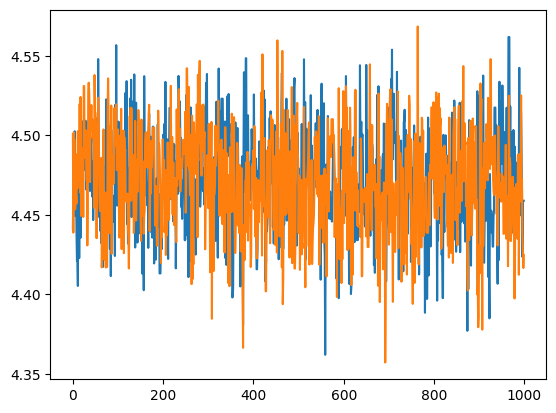

In [97]:
f= states.position['f']
plt.plot(f[0, :])
plt.plot(f[1, :])

In [98]:
effective_sample_size(f, chain_axis=0, sample_axis=1)

Array(29850.23346792, dtype=float64)